### 导入autoload扩展

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 下载并载入[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)数据集

In [30]:
from utils import *
from itertools import product
from copy import deepcopy

data = download_minist()

### 封装训练函数

In [21]:
from full_connect_network import FullConnectNet
from solve import Solver

def train_with_params(
        hidden_dims, 
        activation, 
        reg, 
        update_rule,
        optim_config,
        lr_decay,
        data: Dict=data,
        weight_scale: float=0.01,
        batch_size: int=64,
        iters: int=6000,
        epochs: int=10,
        plot: bool=True,
        verbose: bool=True
    ):
    
    three_layer_model = FullConnectNet(
        hidden_dims=hidden_dims, 
        activation=activation, 
        reg=reg,
        weight_scale=weight_scale 
    )

    three_layer_net = Solver(
        model=three_layer_model, 
        data=data,
        update_rule=update_rule,
        optim_config=optim_config,
        lr_decay=lr_decay,
        batch_size=batch_size,
        print_iter=500,
        iters=iters,
        num_epochs=epochs,
        verbose=verbose
    )

    three_layer_net.train() 
    if plot:
        plot_stats_single(three_layer_net) 
    return three_layer_net

### 设置默认参数值

In [22]:
default_params = {
    'hidden_dims': [128, 64], 
    'activation': ['relu'],
    'reg': 1e-2,
    'update_rule': 'sgd',
    'optim_config': {
        'learning_rate': 1e-3
    },
    'lr_decay': 0.9
}

### 过拟合小数据集

(Time   0.00 s; Iteration     1 /  2000) loss 2.363608
[Epoch  0 / 10] train accuracy: 0.110000; val accuracy: 0.104200
[Epoch  1 / 10] train accuracy: 0.704000; val accuracy: 0.649800
[Epoch  2 / 10] train accuracy: 0.820000; val accuracy: 0.708300
(Time   1.15 s; Iteration   501 /  2000) loss 0.466822
[Epoch  3 / 10] train accuracy: 0.902000; val accuracy: 0.756000
[Epoch  4 / 10] train accuracy: 0.944000; val accuracy: 0.769200
[Epoch  5 / 10] train accuracy: 0.960000; val accuracy: 0.774100
(Time   2.28 s; Iteration  1001 /  2000) loss 0.234394
[Epoch  6 / 10] train accuracy: 0.976000; val accuracy: 0.771700
[Epoch  7 / 10] train accuracy: 0.994000; val accuracy: 0.775800
(Time   3.26 s; Iteration  1501 /  2000) loss 0.153984
[Epoch  8 / 10] train accuracy: 0.998000; val accuracy: 0.776700
[Epoch  9 / 10] train accuracy: 1.000000; val accuracy: 0.775000
[Epoch 10 / 10] train accuracy: 1.000000; val accuracy: 0.777300


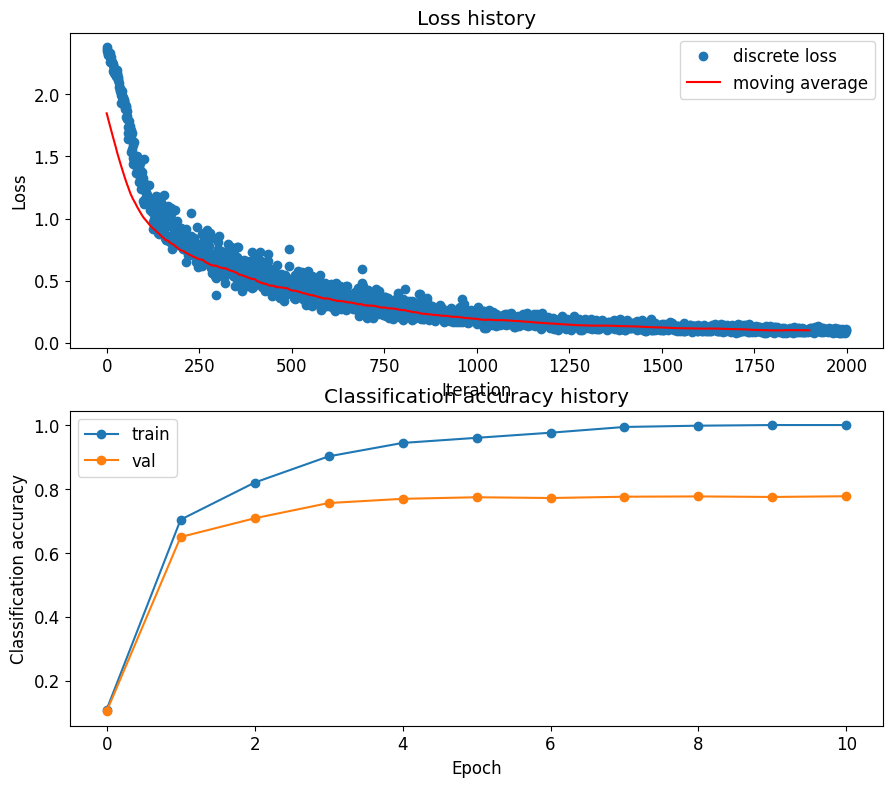

In [25]:
np.random.seed(419)
# get the first 500 samples of the testing dataset
small_data = deepcopy(data)
small_data['X_train'] = small_data['X_train'][:500]
small_data['y_train'] = small_data['y_train'][:500]

small_nn = train_with_params(
    **default_params,
    iters=2000,
    data=small_data
)

### 尝试不同组合的激活函数

Activation: (   relu,    relu) has been trained successfully!
Activation: (   relu, sigmoid) has been trained successfully!
Activation: (   relu,    tanh) has been trained successfully!
Activation: (sigmoid,    relu) has been trained successfully!
Activation: (sigmoid, sigmoid) has been trained successfully!
Activation: (sigmoid,    tanh) has been trained successfully!
Activation: (   tanh,    relu) has been trained successfully!
Activation: (   tanh, sigmoid) has been trained successfully!
Activation: (   tanh,    tanh) has been trained successfully!


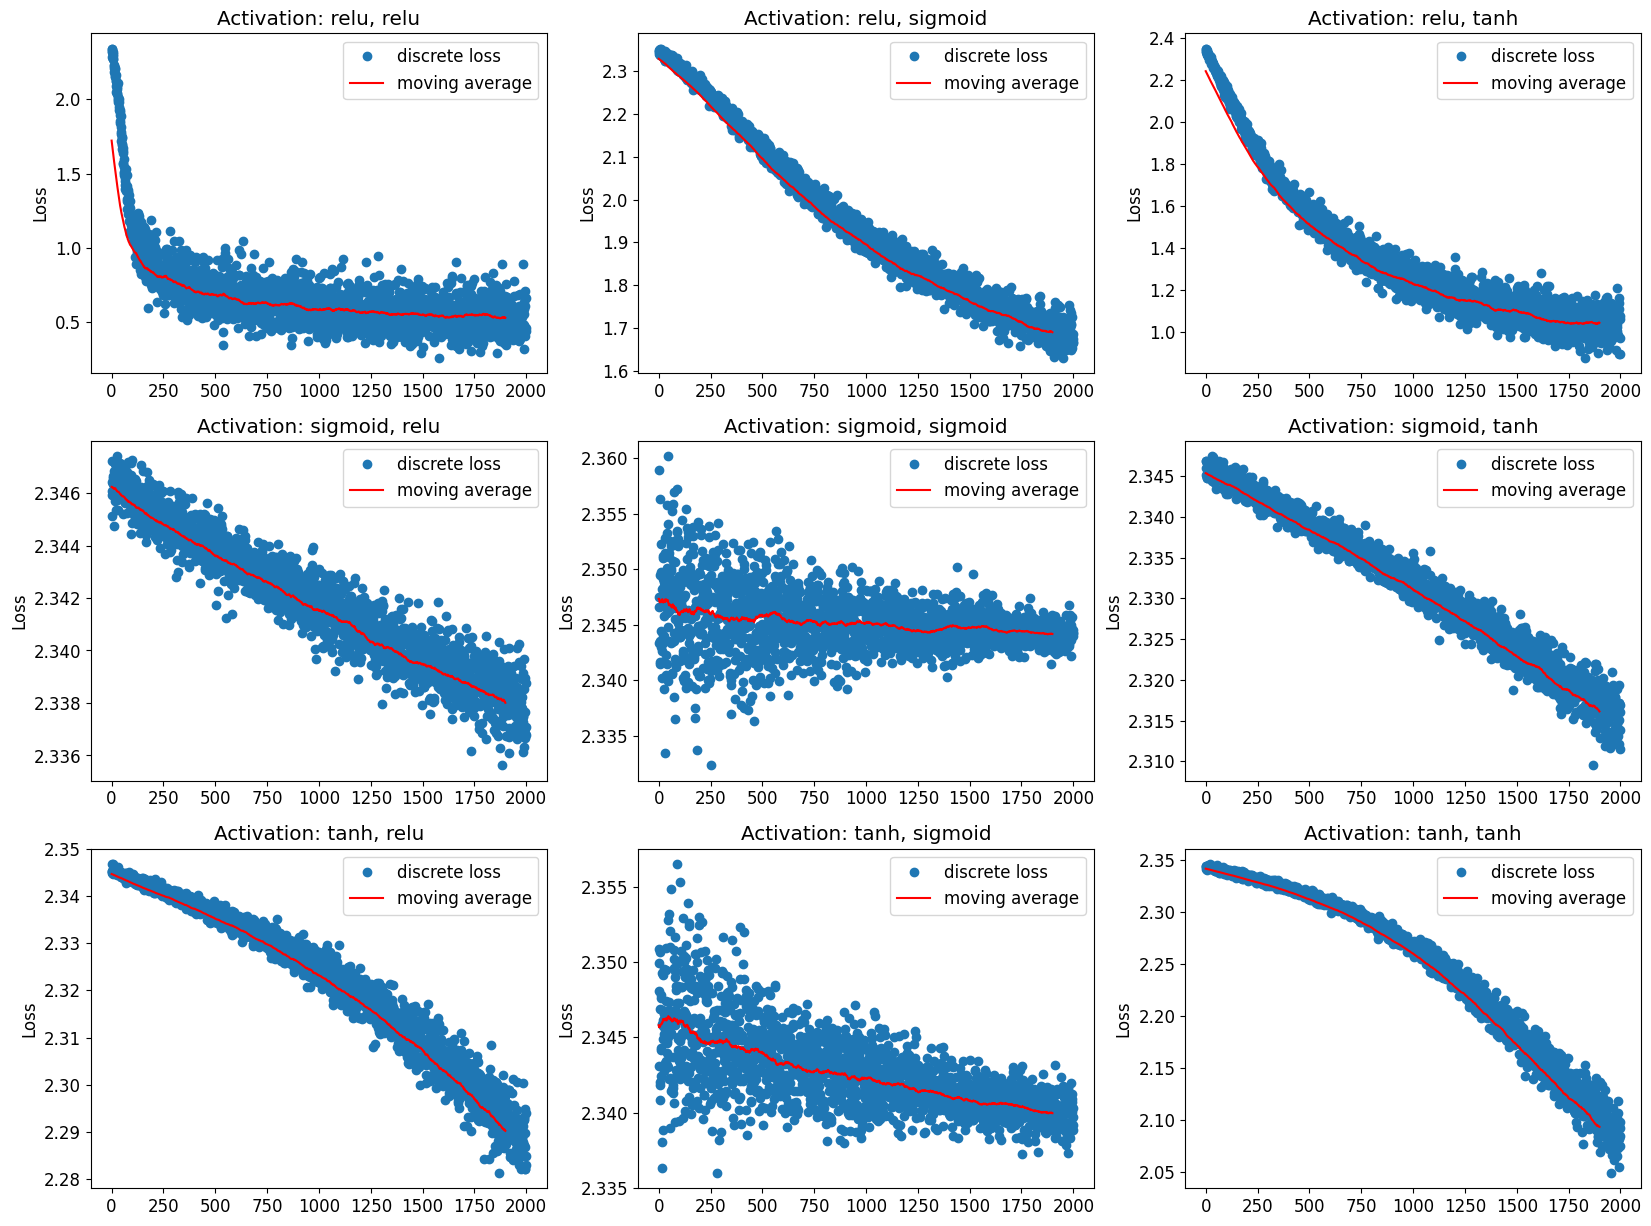

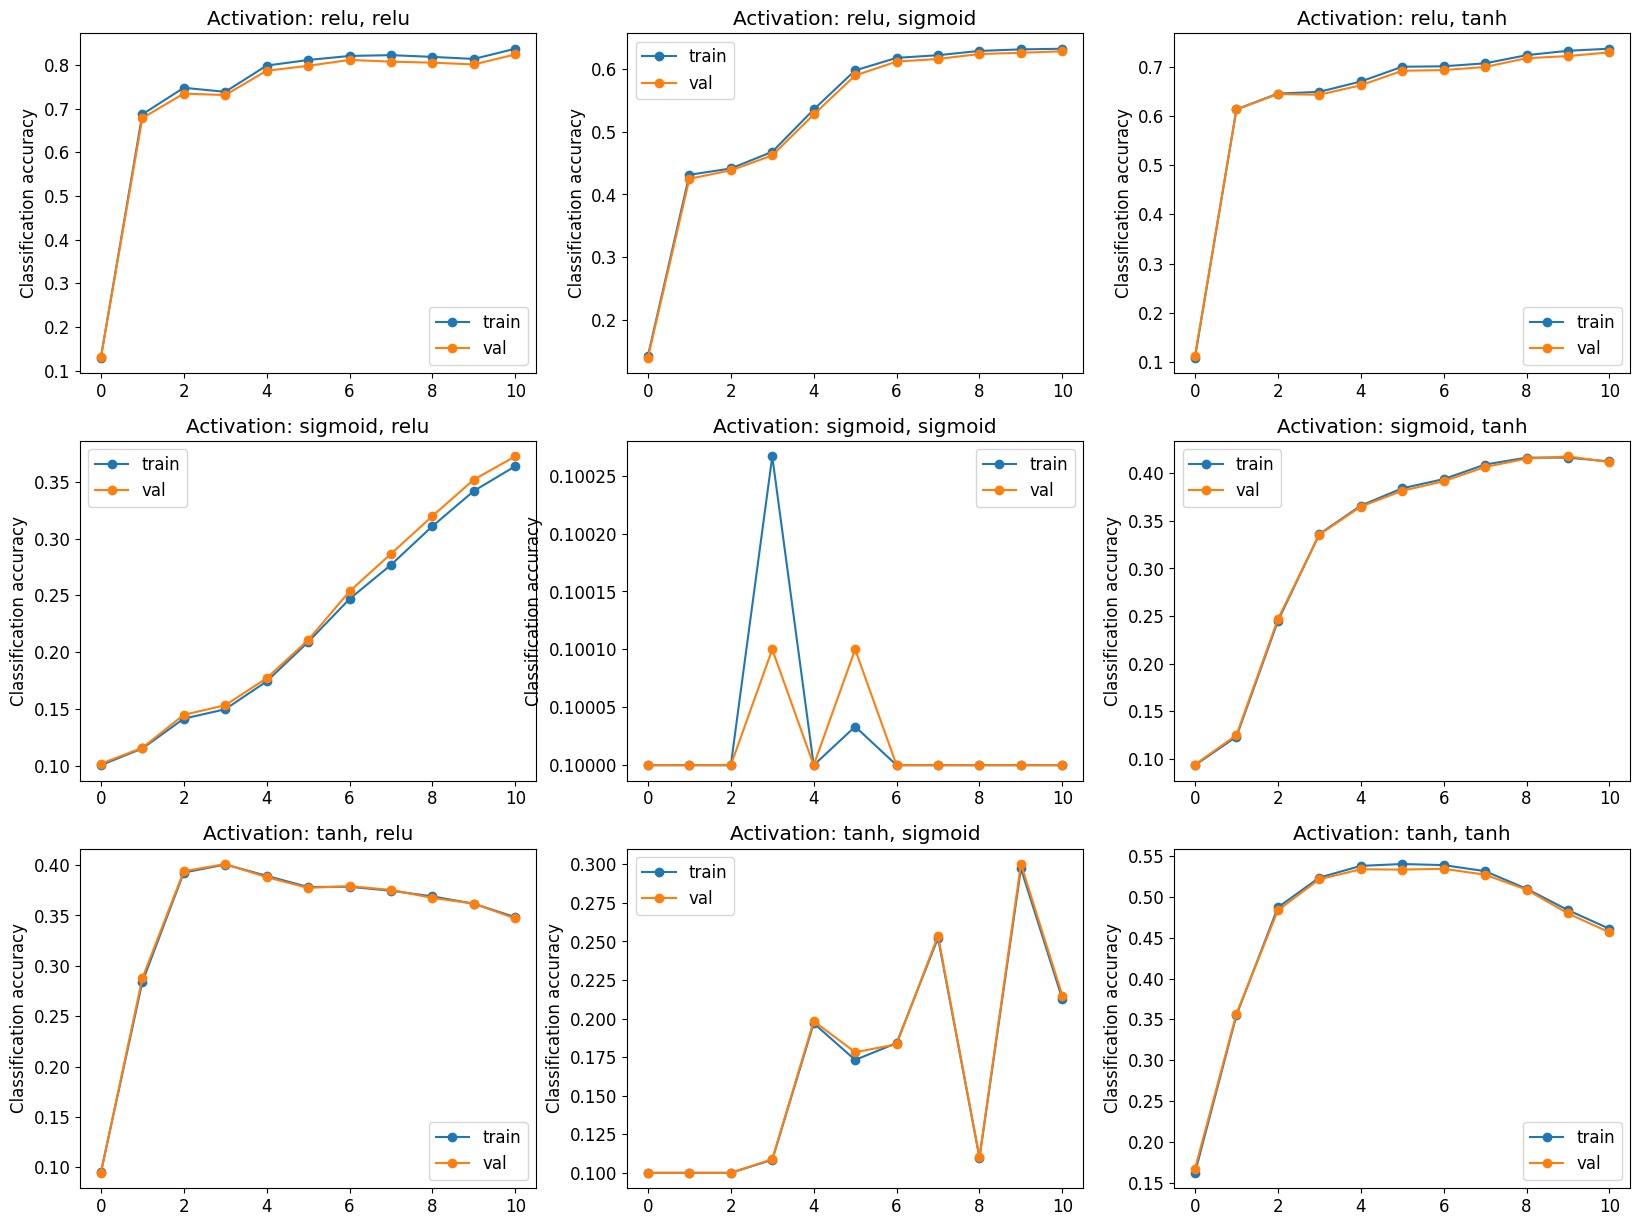

In [27]:
np.random.seed(424)

activations = ['relu', 'sigmoid', 'tanh']
avtivation_config = list(product(activations, activations))
window_size = 100

act_params = deepcopy(default_params)

# train the model based on different activation functions
nets = []

for config in avtivation_config:
    act_params['activation'] = list(config) # modify the activation functions
    act_nn = train_with_params(
        **act_params,
        iters=2000,
        plot=False,
        verbose=False
    )
    nets.append(act_nn)
    print('Activation: ({:>7}, {:>7}) has been trained successfully!'.format(*config))

# plot the training loss
fig_loss, axes_loss = plt.subplots(3, 3, figsize=(20, 15))
axes_loss = axes_loss.flatten()

for act_nn, ax in zip(nets, axes_loss): 
    ax.plot(act_nn.loss_hist, 'o', label='discrete loss')
    ax.plot([sum(act_nn.loss_hist[i:i+window_size])/window_size for i in range(len(act_nn.loss_hist)-window_size)], 'red', label='moving average')
    ax.set_title('Activation: {}, {}'.format(act_nn.model.params['A1'], act_nn.model.params['A2']))
    ax.set_ylabel("Loss")
    ax.legend()

# plot the accuracy curve
fig_acc, axes_acc = plt.subplots(3, 3, figsize=(20, 15))
axes_acc = axes_acc.flatten()

for act_nn, ax in zip(nets, axes_acc):
    ax.plot(act_nn.train_acc_hist, 'o-', label='train')
    ax.plot(act_nn.val_acc_hist, 'o-', label='val')
    ax.legend()
    ax.set_title('Activation: {}, {}'.format(act_nn.model.params['A1'], act_nn.model.params['A2']))
    ax.set_ylabel('Classification accuracy')


### 正则化参数，学习率，隐藏层大小

In [58]:
np.random.seed(425)

# NOTE: you can change the hyper-parameters here
hidden_dims = [[128, 64], [128, 48], [ 64, 48]]
learning_rate = [1e-4, 1e-3, 1e-2]
reg = [1e-3, 1e-2, 1e-1]

# generate the configurations and validation indices
hyper_params_configs = list(product(hidden_dims, learning_rate, reg))
k = 5
val_indices = train_val_split(data, k)

tune_params = deepcopy(default_params)
tune_data = deepcopy(data)
tune_acc = []

print("Total {} configurations".format(len(hyper_params_configs)))

# grid search
for index, config in enumerate(hyper_params_configs):
    tune_params['hidden_dims'], tune_params['reg'] = config[0], config[2]
    tune_params['optim_config'] = {'learning_rate': config[1]}
    accuracy = 0.

    print("[{:>2} / {}] Training with configuration:( hidden_dims={}, learning_rate={:>6.4f}, reg={:>6.4f})...".format(
        index + 1,
        len(hyper_params_configs),
        *config
    ))
    # k folds
    for i in range(k):
        # split the training dataset into train&validation dataset
        val_indice = val_indices[i]
        train_indices = np.ones(len(data['X_train']), dtype=bool)
        train_indices[val_indice] = False
        train_indices, val_indice = map(list, [train_indices, val_indice])
        tune_data['X_train'] = data['X_train'][train_indices]
        tune_data['y_train'] = data['y_train'][train_indices]
        tune_data['X_val'] = data['X_train'][val_indice]
        tune_data['y_val'] = data['y_train'][val_indice]
        # train
        grid_nn = train_with_params(
            **tune_params,
            iters=2000,
            data=tune_data,
            plot=False,
            verbose=False
        )
        # print the accuracy
        accuracy += grid_nn.best_val_acc
        print("         [Fold {} / {}] --> validation accuracy: {:>6.4f}".format(i + 1, k, grid_nn.best_val_acc))
    accuracy /= 5
    tune_acc.append(accuracy)
    print("         Configuration: hidden_dims={}, learning_rate={:>6.4f}, reg={:>6.4f}. Average val accuracy: {:>8.6f}".format(
        *config, accuracy
    ))
    print("*" * 100)



Total 27 configurations
[ 1 / 27] Training with configuration:( hidden_dims=[128, 64], learning_rate=0.0001, reg=0.0010)...
         [Fold 1 / 5] --> validation accuracy: 0.6562
         [Fold 2 / 5] --> validation accuracy: 0.6698
         [Fold 3 / 5] --> validation accuracy: 0.6558
         [Fold 4 / 5] --> validation accuracy: 0.6597
         [Fold 5 / 5] --> validation accuracy: 0.6731
         Configuration: hidden_dims=[128, 64], learning_rate=0.0001, reg=0.0010. Average val accuracy: 0.662900
****************************************************************************************************
[ 2 / 27] Training with configuration:( hidden_dims=[128, 64], learning_rate=0.0001, reg=0.0100)...
         [Fold 1 / 5] --> validation accuracy: 0.6496
         [Fold 2 / 5] --> validation accuracy: 0.6552
         [Fold 3 / 5] --> validation accuracy: 0.6556
         [Fold 4 / 5] --> validation accuracy: 0.6486
         [Fold 5 / 5] --> validation accuracy: 0.6482
         Configuration:

### 不同的更新方式

In [ ]:
update_rules = ['sgd', 'sgd_momentum', 'adam', 'rmsprop']
window_size = 100

update_params = deepcopy(default_params)
for update_rule in update_rules:
    update_params['update_rule'] = update_rule
    update_nn = train_with_params(
        **update_params,
        iters=2000,
        verbose=False,
        plot=False
    )

    plt.plot([sum(update_nn.loss_hist[i:i+window_size])/window_size for i in range(len(update_nn.loss_hist)-window_size)], 'red', label=update_rule)
    
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()


### 完整训练

In [ ]:
np.random.seed(419)

hidden_dims = [128, 64]
activation = ['relu', 'tanh']
reg = 1e-3

update_rule = 'sgd'
optim_config = {
    'learning_rate': 5e-3
}
lr_decay=0.9
batch_size=64
print_iter=500
iters=60000
epochs=30

nn = train_with_params(
        hidden_dims=hidden_dims, 
        activation=activation, 
        reg=reg, 
        update_rule=update_rule,
        optim_config=optim_config,
        lr_decay=lr_decay,
        batch_size=batch_size,
        iters=iters,
        epochs=epochs
    )

# save the best model
# model_path = 'fcnn'
# nn.save(model_path)

### 可视化权重

In [ ]:
show_net_weights(nn)
# TODO: Visualize images of different labels after some layers

```python
# sgd_momentum
{
    hidden_dims = [128, 64, 32]
    activation = ['relu']
    reg = 1e-3
    loss = 'ce'
    three_layer_model = FullConnectNet(
        hidden_dims=hidden_dims, 
        types=activation, 
        reg=reg, 
        loss=loss
    )
    three_layer_net = Solver(
        model=three_layer_model, 
        data=data,
        update_rule='sgd_momentum',
        optim_config = {
            'learning_rate': 1e-2
        },
        lr_decay=0.9 / 0.8,
        batch_size=64,
        print_iter=100
    )
}
# adam
{
    hidden_dims = [64, 32]
    activation = ['relu']
    reg = 1e-3
    loss = 'ce'

    update_rule = 'adam'
    optim_config = {
        'learning_rate': 1e-4
    }
    lr_decay=0.8
    batch_size=128
    print_iter=500
    iters=20000
}
# sgd
{
    hidden_dims = [128, 64]
    activation = ['relu']
    reg = 1e-3
    loss = 'ce'

    update_rule = 'sgd'
    optim_config = {
        'learning_rate': 5e-3
    }
    lr_decay=0.9
    batch_size=64
    print_iter=500
    iters=2000
}

```